## Goals: Training the *Final* Models

This notebook trains the model on the full *baseline_dataset* for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic *regions*.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.

In [40]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import lightgbm as lgb

from sklearn import svm
from mapie.regression import MapieRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from src.utils.model import split_dataset, compare_models_per_station, create_deep_model

##### Constants :
- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **mapie**: Combines LightGBM with MAPIE. **MAPIE** (Model Agnostic Prediction Interval Estimator) computes prediction intervals for any regression model using conformal methods.
- **qrf**: Quantile Random Forest (natively produces prediction intervals)
- **ebm**: Explainable Boosting Machine is used as a exemple that does not natively implement prediction intervals, but that can be customised to do so.

In [41]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

DATASET_SPEC = "full_pca"

MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4

mapie_svm = {}

COLUMNS_TO_DROP = ["water_flow_week1", "water_flow_week2", "water_flow_week3", "water_flow_week4"]


### 2. Data Loading
Load in the baseline datasets, create the directory to save models.

In [42]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

Data pre-processing removal of unnecessary columns, setup of the target

In [43]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)
y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    y_train[i] = dataset_train[f"water_flow_week{i+1}"]


### 2. Models training
#### a. SVM + MAPIE

## Mapie Model Training Overview

- **Configuration:**  
  - Sets `ALPHA` (0.1) as the prediction interval level.
  - Defines `TIME_VALIDATION` as a split point for creating a validation set.
  - Configures LightGBM parameters (`LGBM_PARAMS`) for quantile regression.




In [44]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

SVM_PARAMS = {
    "max_depth": 15,
    "learning_rate": 0.01,
    "n_estimators": 500,
    "colsample_bytree": 0.7,
    "objective": "quantile",
    "alpha": ALPHA
}

- **Data Preparation:**  
  - Splits `dataset_train` into training and validation subsets using `split_dataset`.
  - Removes unnecessary columns from both the training and validation datasets.
  - Extracts target variables for each week (from `water_flow_week1` to `water_flow_week4`).

- **Model Training:**  
  For each week:
  - Initializes a LightGBM regressor with the specified parameters.
  - Wraps it in a `MapieQuantileRegressor` to estimate prediction intervals.
  - Trains the model on the training data and calibrates it using the validation data.
  - Saves the trained model 

In [48]:
print("Training SVM")
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from quantile_forest import RandomForestQuantileRegressor

initial_model = RandomForestQuantileRegressor(n_estimators= 45, min_samples_split= 2, min_samples_leaf= 9, max_features= None, max_depth= 30)
train_mapie_svm, val_mapie_svm, val_temporal  = split_dataset(dataset_train, 0.75, TIME_VALIDATION)    

X_train_mapie_svm = train_mapie_svm.drop(columns=COLUMNS_TO_DROP)
X_train_mapie_svm = X_train_mapie_svm.drop(columns=["station_code"])
print(len(X_train_mapie_svm.columns))
y_train_mapie_svm = {}
for i in range(0, NUMBER_OF_WEEK):
    y_train_mapie_svm[i] = train_mapie_svm[f"water_flow_week{i+1}"]

X_val = val_mapie_svm.drop(columns=COLUMNS_TO_DROP)
X_val = X_val.drop(columns=["station_code"])
y_val = {}
y_val[0] = val_mapie_svm["water_flow_week1"]
for i in range(1, NUMBER_OF_WEEK):
    y_val[i] = val_mapie_svm[f"water_flow_week{i+1}"]

for i in range(NUMBER_OF_WEEK):
    print(f"Training week {i}")

    # Initialize and train Model
    mapie_svm[i] = BaggingRegressor(estimator=initial_model, n_estimators=3, random_state=0)
    mapie_svm[i].fit(X_train_mapie_svm, y_train_mapie_svm[i])
    
    # Initialize and train Mapie
    # mapie_svm[i] = MapieRegressor(estimator=model, method="plus", cv=5)
    # mapie_svm[i].fit(X_train_mapie_svm, y_train_mapie_svm[i])
    
    # save model with date
    time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

    model_path = f"{MODEL_DIR}final/qrf_bagging_quantile_{time}_week_{i}.pkl"
    joblib.dump(mapie_svm[i], model_path)


Training SVM
44
Training week 0
Training week 1
Training week 2
Training week 3


### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: Use

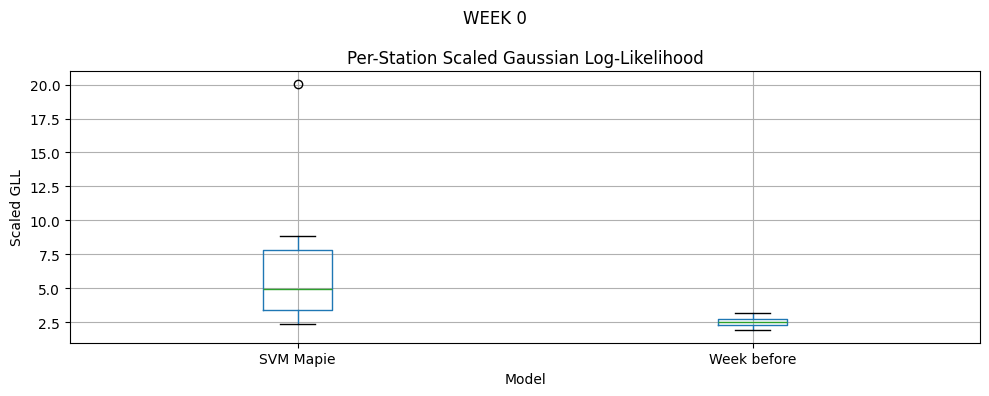

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: Use

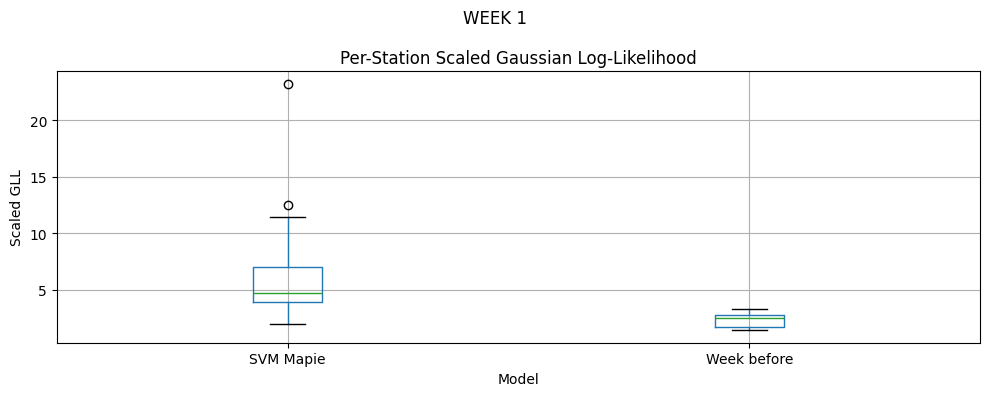

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: Use

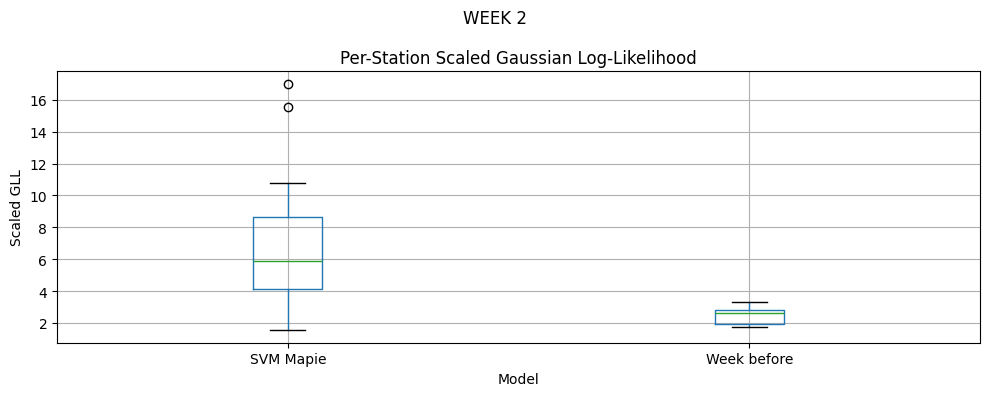

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: Use

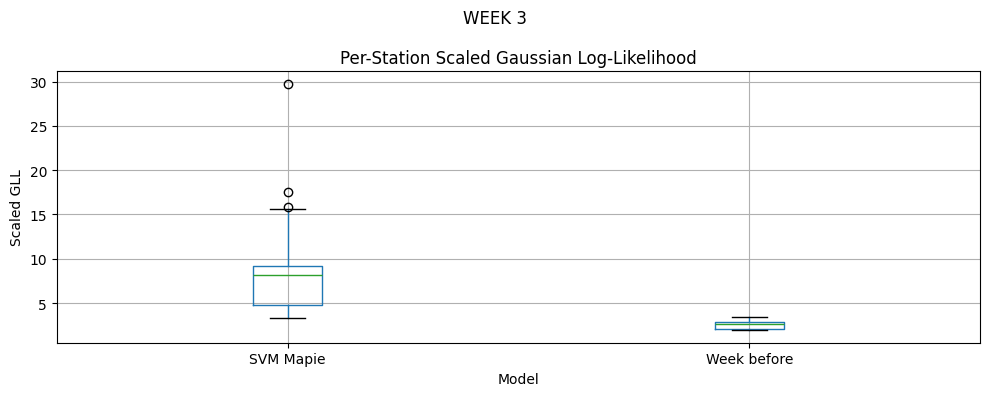

In [49]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"])
for i in range(NUMBER_OF_WEEK):
    predictions = []
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append({"model": "Week before", "prediction": baseline_day_before, "dataset":"train", "stations": y_train_stations, "prediction_interval": None})
    

    y_pred_mapie_svm = np.mean([est.predict(X_train_eval) for est in mapie_svm[i].estimators_], axis=0)
    y_pis_mapie_svm = np.stack([np.quantile([est.predict(X_train_eval) for est in mapie_svm[i].estimators_], 0.05, axis=0),
                                np.quantile([est.predict(X_train_eval) for est in mapie_svm[i].estimators_], 0.95, axis=0)], axis=1)
    
    # y_pred_mapie_svm = mapie_svm[i].predict(X_train_eval, alpha=0.5)
    # y_pis_mapie_svm = np.stack([mapie_svm[i].predict(X_train_eval, quantiles=0.05), mapie_svm[i].predict(X_train_eval, quantiles=0.95)], axis=1)
    predictions.append({"model": "SVM Mapie",
                            "prediction": y_pred_mapie_svm,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_mapie_svm})
        
    compare_models_per_station(
        y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood" ,
        title = f"WEEK {i}")

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [47]:
for i in range(NUMBER_OF_WEEK):

    baseline_day_before = dataset_train["water_flow_lag_1w"]
    # if "qrf" in FINAL_MODELS:
    if True:
        y_pred_qrf_bagging = np.mean([est.predict(X_train_eval, quantiles="mean") for est in mapie_svm[i].estimators_], axis=0)
        y_pis_qrf_bagging = np.mean(np.stack(
                [
                    [
                        est.predict(X_train_eval, quantiles=[ALPHA / 2])
                        for est in mapie_svm[i].estimators_
                    ],
                    [
                        est.predict(X_train_eval, quantiles=[ 1 - ALPHA / 2])
                        for est in mapie_svm[i].estimators_
                    ]
                ],
                axis=1,
            ), axis=0)
        print(y_pred_qrf_bagging.shape)
        print(y_pis_qrf_bagging.shape)
        coverage = (y_train[i].values >= y_pis_qrf_bagging[0,:]) & (y_train[i].values <= y_pis_qrf_bagging[1,:])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: Use

(28431,)
(2, 28431)
QRF coverage of the prediction interval for week 0: 0.9382012591889135


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: Use

(28431,)
(2, 28431)
QRF coverage of the prediction interval for week 1: 0.9375681474446906


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: Use

(28431,)
(2, 28431)
QRF coverage of the prediction interval for week 2: 0.9316942773732897


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: Use

(28431,)
(2, 28431)
QRF coverage of the prediction interval for week 3: 0.9282825085294221


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
